In [ ]:
import numpy as np, torch, time, os
from Ctubes.geometry_utils import (
    rotate_about_axis, compute_tangents, reflect_about_plane, 
    compute_quad_normals, get_bisecting_plane_normals_with_symmetry
)
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_all, load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figure 15: Rocking Chair

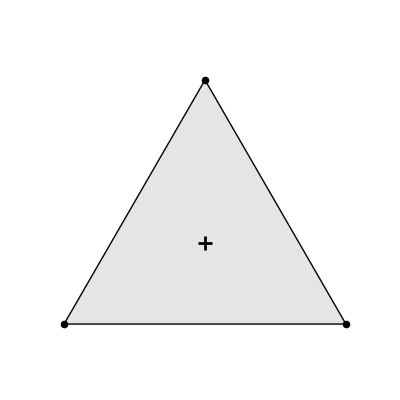

In [3]:
# Generatrix: regular N-gon
N = 3
tube_radius = 0.4

interior_angle = (N - 2) * PI / N
generatrix_2d = torch.zeros(size=(N, 2))
t = torch.linspace(-interior_angle/2, 2*PI - interior_angle/2, N + 1)
generatrix_2d[:, 0] = tube_radius * torch.cos(t[:-1])
generatrix_2d[:, 1] = tube_radius * torch.sin(t[:-1])

fig, ax = plot_generatrix(generatrix_2d)

In [4]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig15_rocking_chair/directrix_Q.obj"))
K = cps_ref.shape[0]
M = (K - 1) * 8 + 1

In [ ]:
# Define symmetry transform
y_axis = torch.tensor([0.0, 1.0, 0.0], dtype=TORCH_DTYPE)
symm_2_fold_reflect = [
    lambda pts: torch.flip(reflect_about_plane(pts, y_axis), dims=[0]),
]
symmetry_transforms = symm_2_fold_reflect

# Select half of the curve
n_fold_symm = 2
K = (K - 1) // n_fold_symm + 1
M = (M - 1) // n_fold_symm + 1
cps_ref = cps_ref[:K]

In [ ]:
# C-tube
directrix = Directrix(cps_ref, M, symmetry_transforms=symmetry_transforms)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

plane_normals = get_bisecting_plane_normals_with_symmetry(directrix)

tube = CTube(
    directrix, generatrix, plane_normals,
    symmetry_transforms=symmetry_transforms
)

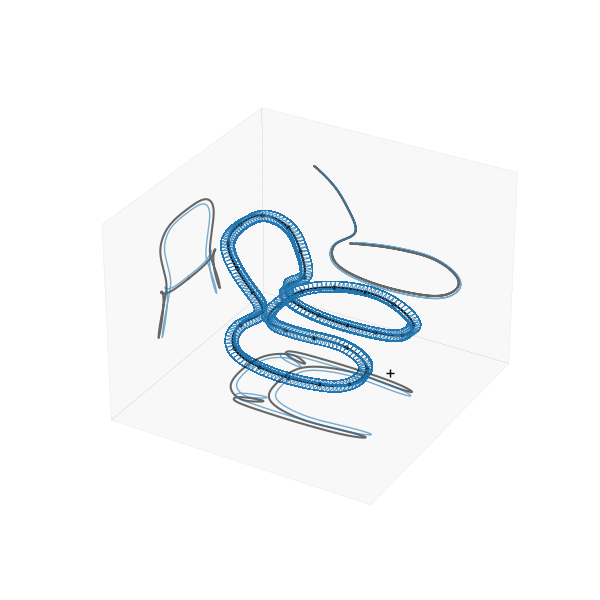

In [9]:
fig, ax = tube.plot_3d()

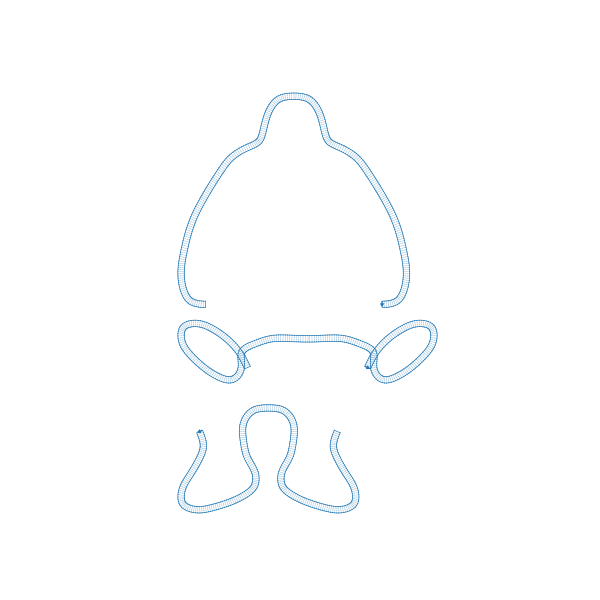

In [10]:
fig, ax = tube.plot_unrolled_strips()

### Orientation constraints

Rockers

In [ ]:
# Select nodes below a certain height to prescribe orientation constraints for the rockers
directrix = tube.get_polyline()
tangents = compute_tangents(directrix)
h_min = torch.min(directrix[:, 2])
h_max = torch.max(directrix[:, 2])
H = h_max - h_min

height_threshold = 1.5 * H / 10
nodes_below_threshold = directrix[:, 2] < h_min + height_threshold
nodes_below_threshold_indices = torch.nonzero(nodes_below_threshold, as_tuple=False)[:, 0]
nodes_below_threshold_indices -= 1  # as we want quads (edge), not nodes; this also avoids selecting the last node

n = nodes_below_threshold_indices.shape[0]
zm = torch.tensor([0.0, 0.0, -1.0])
quad_orient_tube_indices_rockers = torch.full((n,), 0)
quad_orient_disc_indices_rockers = nodes_below_threshold_indices
strip_index = 2
quad_orient_cross_section_indices_rockers = torch.full((n,), strip_index)

# Compute targets as current normals with y component zeroed out
ctube_vertices = tube.compute_vertices_with_symmetry()
normals_rockers = compute_quad_normals([ctube_vertices], quad_orient_tube_indices_rockers, quad_orient_disc_indices_rockers, quad_orient_cross_section_indices_rockers)
quad_orient_target_rockers = normals_rockers
quad_orient_target_rockers[:, 1] = 0.0
quad_orient_target_rockers = quad_orient_target_rockers / torch.linalg.norm(quad_orient_target_rockers, dim=1).unsqueeze(1)

Headrest

In [ ]:
# Select nodes above a certain height to prescribe orientation constraints for the headrest
height_threshold = 9 * H / 10
nodes_below_threshold = directrix[:, 2] > h_min + height_threshold
nodes_below_threshold_indices = torch.nonzero(nodes_below_threshold, as_tuple=False)[:, 0]
nodes_below_threshold_indices -= 1  # as we want quads (edge), not nodes – this also avoids selecting the last node

n = nodes_below_threshold_indices.shape[0]
xp = torch.tensor([1.0, 0.0, 0.0])
quad_orient_tube_indices_headrest = torch.full((n,), 0)
quad_orient_disc_indices_headrest = nodes_below_threshold_indices
strip_index = 0
quad_orient_cross_section_indices_headrest = torch.full((n,), strip_index)

# Compute targets as current normals with additional rotation about the curve tangent
normals_headrest = compute_quad_normals([ctube_vertices], quad_orient_tube_indices_headrest, quad_orient_disc_indices_headrest, quad_orient_cross_section_indices_headrest)
for li, gi in enumerate(quad_orient_disc_indices_headrest):
    tangent = tangents[gi]
    angle = torch.tensor(PI/6)
    normals_headrest[li] = rotate_about_axis(normals_headrest[li].reshape(-1, 3), angle=angle, axis=tangent)
quad_orient_target_headrest = normals_headrest / torch.linalg.norm(normals_headrest, dim=1).unsqueeze(1)

Seat

In [ ]:
# Select starting points, up to a threshold value of the curve parameter, for the seat
n_starting_points = tube.M // 6
quad_orient_tube_indices_seat = torch.full((n_starting_points,), 0)
quad_orient_disc_indices_seat = torch.arange(n_starting_points)
strip_index = 2
quad_orient_cross_section_indices_seat = torch.full((n_starting_points,), strip_index)

# Compute targets as current normals with additional rotation about the curve tangent
normals_seat = compute_quad_normals([ctube_vertices], quad_orient_tube_indices_seat, quad_orient_disc_indices_seat, quad_orient_cross_section_indices_seat)
quad_orient_target_seat = normals_seat / torch.linalg.norm(normals_seat, dim=1).unsqueeze(1)

In [44]:
quad_orient_tube_indices = torch.cat([quad_orient_tube_indices_rockers, quad_orient_tube_indices_headrest, quad_orient_tube_indices_seat])
quad_orient_disc_indices = torch.cat([quad_orient_disc_indices_rockers, quad_orient_disc_indices_headrest, quad_orient_disc_indices_seat])
quad_orient_cross_section_indices = torch.cat([quad_orient_cross_section_indices_rockers, quad_orient_cross_section_indices_headrest, quad_orient_cross_section_indices_seat])
quad_orient_target = torch.cat([quad_orient_target_rockers, quad_orient_target_headrest, quad_orient_target_seat])

### Optimization

In [ ]:
# Load target cross-section radii from file
target_cross_section_radii = torch.tensor(
    np.loadtxt(os.path.join(paths["data"], "fig15_rocking_chair/target_cross_section_radii.txt")), 
    dtype=TORCH_DTYPE
)

In [ ]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_section_radius': 5.25e1 / generatrix.aabb_diagonal_length() ** 2,
    'join_ends': 1.0 / generatrix.aabb_diagonal_length() ** 2,
    'smooth_plane_normal_diffs': 1e-1,
    'smooth_apex_loc_func': 1e2,
    'quad_orientation': 1e1,
}

objective_args = {
    
    # Target cross-section radius
    'target_cross_section_radii': target_cross_section_radii,

    # Join ends
    'join_ends_pairings': get_pairings_all(N),

    # Quad orientation
    'quad_orient_tube_indices': quad_orient_tube_indices,
    'quad_orient_disc_indices': quad_orient_disc_indices,
    'quad_orient_cross_section_indices': quad_orient_cross_section_indices,
    'quad_orient_target': quad_orient_target,
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(True)
opt_prob.activate_apex_loc_func(True)
opt_prob.activate_plane_normals(True)

In [19]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000000000
match_target_cross_section_radius       : 0.1589224924
join_ends                               : 0.0000000000
smooth_plane_normal_diffs               : 0.0000257467
smooth_apex_loc_func                    : 0.0000000000
quad_orientation                        : 2.5136672522
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000000000


tensor(2.6726)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []  # no fixed DOF by default
dofs = opt_prob.get_dof_indices_plane_normals()
fixed_indices += dofs[:6] + dofs[-6:]  # fix first two and last two plane normals
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 12 parameters.


In [21]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 1000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          514     M =           10

At X0        12 variables are exactly at the bounds

At iterate    0    f=  2.67262D+00    |proj g|=  1.87224D+01

At iterate    1    f=  1.22938D+00    |proj g|=  6.36056D+00

At iterate    2    f=  5.27295D-01    |proj g|=  3.90525D+00

At iterate    3    f=  3.61503D-01    |proj g|=  1.21500D+00

At iterate    4    f=  2.66953D-01    |proj g|=  3.85788D-01

At iterate    5    f=  1.59742D-01    |proj g|=  8.82700D-01

At iterate    6    f=  8.44482D-02    |proj g|=  4.41265D-01

At iterate    7    f=  6.61996D-02    |proj g|=  5.10081D-01

At iterate    8    f=  5.28331D-02    |proj g|=  1.66489D-01

At iterate    9    f=  4.86235D-02    |proj g|=  1.17518D-01

At iterate   10    f=  3.25598D-02    |proj g|=  8.46167D-02

At iterate   11    f=  2.13484D-02    |proj g|=  1.48577D-01

At iterate   12    f=  1.56297D-02    |proj g|=  1.28677D-01

At iterate   13    f=  1.4

In [22]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000000000
match_target_cross_section_radius       : 0.0000049928
join_ends                               : 0.0000002865
smooth_plane_normal_diffs               : 0.0000334237
smooth_apex_loc_func                    : 0.0000235388
quad_orientation                        : 0.0000088034
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000000064


tensor(7.1052e-05)

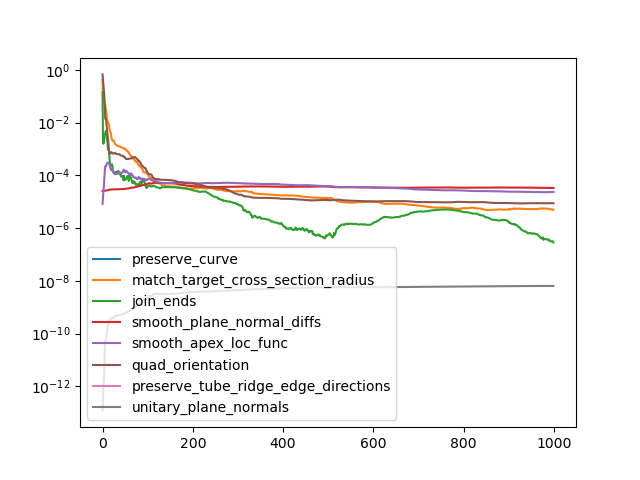

In [23]:
fig, ax = opt_prob.plot_objective_history()

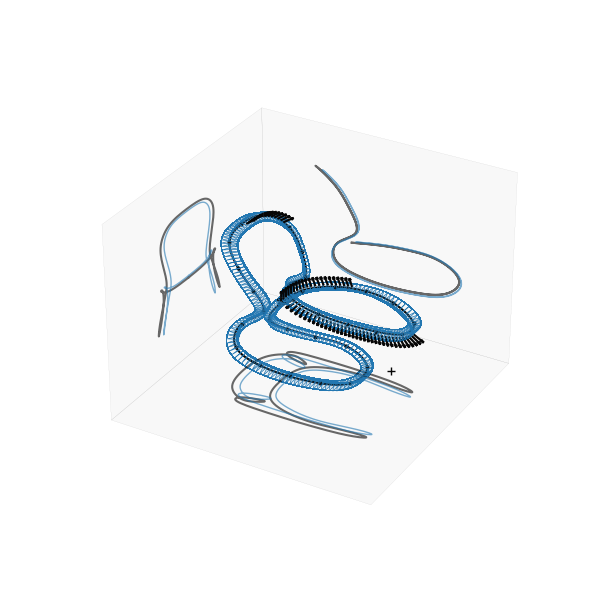

In [24]:
fig, ax = opt_prob.plot_3d()

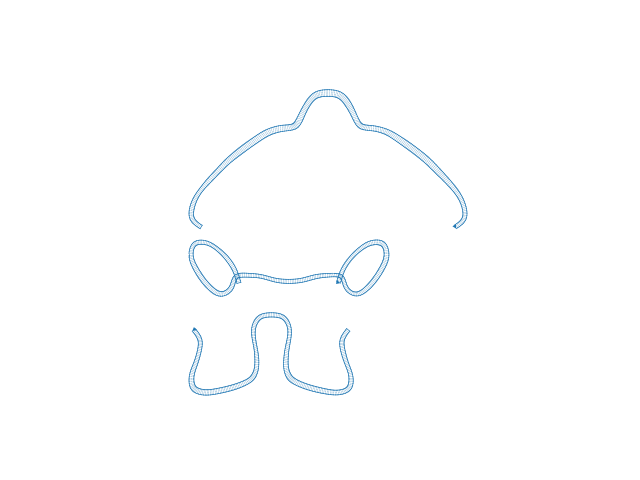

In [25]:
fig, ax = opt_prob.plot_unrolled_strips()

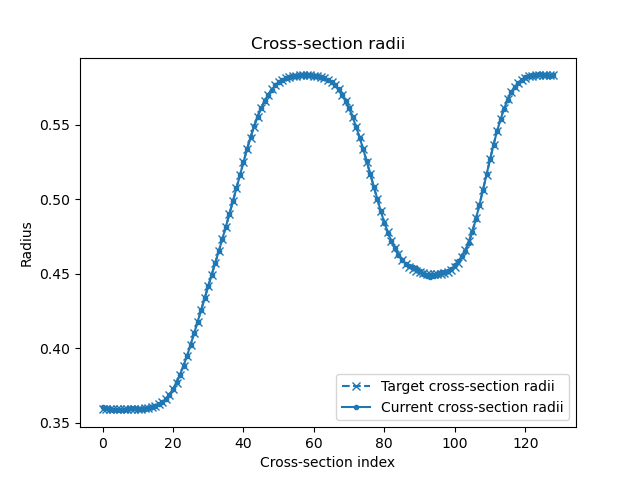

In [26]:
fig, ax = opt_prob.plot_cross_section_radii()

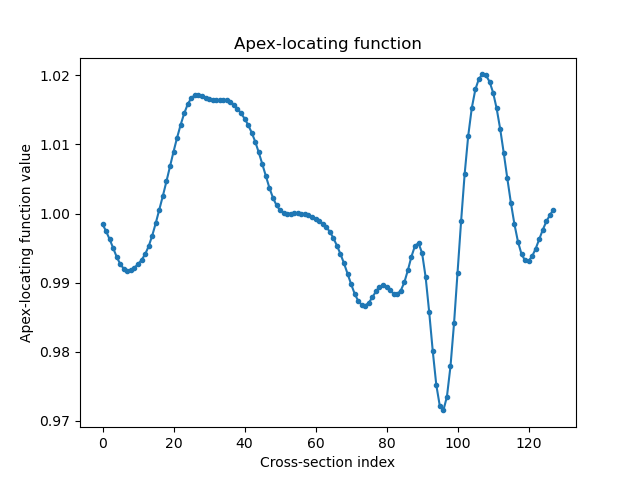

In [27]:
fig, ax = opt_prob.plot_apex_loc_func()

In [ ]:
# Export quad orientation data as obj
# Each orientation vector is represented as a segment with the origin at the quad center
# and the orientation vector as the direction
from Ctubes.geometry_utils import compute_quad_centers

quad_orient_tube_indices = opt_prob.objective_args['quad_orient_tube_indices']
quad_orient_disc_indices = opt_prob.objective_args['quad_orient_disc_indices']
quad_orient_cross_section_indices = opt_prob.objective_args['quad_orient_cross_section_indices']
quad_orient_target = opt_prob.objective_args['quad_orient_target']
vertices = opt_prob.tube_network.compute_vertices()

# Symmetrize all data w.r.t. the xz-plane
quad_orient_tube_indices_full = torch.cat([quad_orient_tube_indices, quad_orient_tube_indices])
quad_orient_disc_indices_full = torch.cat([quad_orient_disc_indices, 2*(tube.M - 1) - 1 - quad_orient_disc_indices])
quad_orient_cross_section_indices_full = torch.cat([quad_orient_cross_section_indices, quad_orient_cross_section_indices])
quad_orient_target_symm = quad_orient_target.clone()
quad_orient_target_symm[:, 1] = -quad_orient_target_symm[:, 1]
quad_orient_target_full = torch.cat([quad_orient_target, quad_orient_target_symm])
vertices_full = [opt_prob.tube_network.tubes[0].compute_vertices_with_symmetry()]

# Compute the quad centers
quad_centers = compute_quad_centers(vertices_full, quad_orient_tube_indices_full, quad_orient_disc_indices_full, quad_orient_cross_section_indices_full)

# Compute the end points of the orientation vectors
quad_orient_target_full = quad_orient_target_full.detach().numpy()
quad_orient_endpoints = quad_centers + quad_orient_target_full

# Write the data to an obj file
obj_file = os.path.join(paths["output_opt"], "quad_orient.obj")
with open(obj_file, 'w') as f:
    for i in range(quad_centers.shape[0]):
        f.write(f"v {quad_centers[i, 0]} {quad_centers[i, 1]} {quad_centers[i, 2]}\n")
        f.write(f"v {quad_orient_endpoints[i, 0]} {quad_orient_endpoints[i, 1]} {quad_orient_endpoints[i, 2]}\n")
        f.write("l -1 -2\n")

# Compute the quad normals
quad_normals = compute_quad_normals(vertices_full, quad_orient_tube_indices_full, quad_orient_disc_indices_full, quad_orient_cross_section_indices_full)

# Translate the normals to the quad centers
quad_normals_endpoints = quad_centers + quad_normals

# Write the data to an obj file
obj_file = os.path.join(paths["output_opt"], "quad_normals.obj")
with open(obj_file, 'w') as f:
    for i in range(quad_centers.shape[0]):
        f.write(f"v {quad_centers[i, 0]} {quad_centers[i, 1]} {quad_centers[i, 2]}\n")
        f.write(f"v {quad_normals_endpoints[i, 0]} {quad_normals_endpoints[i, 1]} {quad_normals_endpoints[i, 2]}\n")
        f.write("l -1 -2\n")